# Bayesian Bandit

### Problem Setting: A/B Test
In many cases we will need to decide which action we should proceed with. For example, we may need to decide which type of logo we want to use, which color we should choose or which promotion we should apply to increase sales of our products or services.

In many cases, this is evaluated using A/B tests where  we run both options we want to decide between for a specified amount of time and then evaluate which campaign, A or B, is more succesful. During the test, we assign which alternative a user sees randomly to a new user. This is fairly easy to do in an online environment as we can assign the "treatment" A or B randomly to new users. In the "offline world", this can be more challenging, for example, we might identify two stores that are very similar and run campaign A in one and B in the other.

However, A/B test do have some disadvantages:
   * Before the A/B test starts, we know (or suspect) already that one of the options will be less performant than the other - otherwise there would be no point in doing the A/B test. However, due to the nature of the A/B test, we have to execute both campaigns A and B for a given amount of time.
   * We have to specify for how long to run the A/B test beforehand, otherwise we risk that we stop the test when we are experiencing a statistical fluctuation.
   * The treatments A and B are fixed during the testing period. However, customer behavior might change while the test runs.
   * A/B tests can be extended to multiple classes, i.e. A/B/C/D-test etc., however, evaluating these tests becomes more complicated.

Bandits can be used to approach the concept of testing in a different way: Each treatment A, B, C, etc. has a given (but unknown) probability of success. Note that we immediately extend testing to more than two classes. We then randomly try each actions and observe the outcome and, as the testing runs, the more successful actions will be used more and more frequently.

### Bayes' Theorem
In order to exploit the information we have as much as possible, we base the analysis on Bayesian statistics.
Remember that Bayes' theorem is given by:
$$ p(\theta|x) = \frac{p(x|\theta) p(\theta)}{p(x)}$$
where $\theta$ is the (set of) parameter(s) we wish to estimate - in our case, the underlying "true" success rate of a given treatment.
In the formula, we have:
   * $p(\theta)$: the prior knowledge of the parameter(s) $\theta$.
   * $p(x)$: the "evidence", essentially a normalization factor
   * $p(x|\theta)$: the likelihood describing how well the data $x$ fit the model with the current parameter(s) $\theta$.
   * $p(\theta|x)$: the posterior, i.e. given the observed data $x$, what are the best values of the model parameters $\theta$. This is the quantity we want to know.

### Choosing the Prior
In many cases, evaluating the posterior probability we are interested in is very difficult and can only be done numerically.
Howerver, in the case of testing different campaigns or treatment, we can use the "trick" of conjugate priors and the evaluation becomes very simple:
Each application of the action A, B, C, etc is a Bernoulli trial which is either successful or not.
We then choose a Beta distribution as the prior. This distribution depends on two parameters $\alpha$ and $\beta$ and describes a continuous probality distri ution in the interval $[0,1]$. When used for the description of Bernoulli trials, $\alpha$ represents the number of successes and $\beta$ the number of failures.

The beta distribution is also the conjugate prior to the Bernoulli, Binomial and negative binomial distribution.
Hence, using a beta distribution for the prior for a Bernoulli trial (the likelihood) implies that the posterior is also a beta distribution and we can calculate the values of the parameters with simple sums.

A special point in the parameter space of the beta function is $\alpha = 1$ and $\beta =1$, which is a flat (uniform) distribution. In terms of Bayesian statistics we can use this special set to model an uninformative prior, i.e. if we don't know anything about the experiment we assume all outcomes are equally likely. Note that this is not always a valid assumption.



  

In [1]:
import numpy as np
import scipy.stats

import matplotlib.pyplot as plt
%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6



Populating the interactive namespace from numpy and matplotlib


## Define the Bandit

We now define a class to describe the bandit.
Each bandit has the properties of the prior, in our case $a$ and $b$ for a Beta distribution.
We also include the true probability of this bandit, i.e. of this option in the real world for convenience. We do not know this in real setting of course - but need it here to simulate the response from the ''real world''.

We initialize each bandit with a uniform prior which is a beta distribution with $\beta(1,1)$, i.e. both parameters are set to one.

The parameters of the beta distribution are:
   * $a$: number of successes
   * $b$: number of failures

In our case, after each action we only have one value: success or failure which
is either 0 (failure) or 1 (success).

When updating the parameters, we can write:
   * $a$ = $a$ + outcome
   * $b$ = $b$ + (1-outcome)

In case of success (outcome = 1) we add this to $a$ and $b$ remains,
in case of failure (outcome = 0), $a$ remains unchanged and we increase $b$.

Note that in real applications we would execute the actual action behind the bandit when we call ```execute()```. In this case, we simulate the response from the environment (success or failure) by returning a random number according to the true success probability of the bandit (which we would not know in a real setting).

In [0]:
class bandit:

  def __init__(self, true_prob):
    self.a = 1
    self.b = 1
    self.true_prob = true_prob

  # get a random number according to the Bayesian prior after the 
  # current number of trials
  def sample(self):
    return np.random.beta(self.a, self.b)

  # update prior parameters with result of executed action
  def update(self, outcome):
    self.a +=  outcome
    self.b += (1-outcome)

  # execute the bandit (i.e. pull the lever)
  def execute(self):
    return np.random.random() < self.true_prob

### Plotting
Define a small helper function to plot the distribution of the
bandits at a few stages during the experiment


In [0]:
def plot(bandits, step):
  x = np.linspace(0,1,200)
  for b in bandits:
    y = scipy.stats.beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label="True probability %.4f" % b.true_prob)
    plt.fill_between(x, 0, y, alpha=0.2)
  plt.title('Result after trials %i' % step)
  plt.legend()
  plt.show()

## Run the Trial

The general approach is:

* Initialize the bandits, one per treatment class with a flat prior, i.e. $\alpha = 1$ and $\beta = 1$.
* Run the trial and keep doing the following:
 * Draw a random number according to the current prior
 * select the bandit with the highest probability of success
 * execute the action for this bandit
 * observe the outcome
 * update the prior.

Note that this setting does not require that we need to define how long we run the trials beforehand. We also do not assume that the response is static.
As the trial runs, the uniform distribution we start with will become more and more well defined. The bandit corresponding to the best action will quickly become dominant, however, since the others have a fairly broad prior, they get sampled occasionally as well.

During the trial we plot the distribution of the priors at various intervals.
In the beginning, all priors are uniform.
As the trial continues, the shape of the priors changes to become more defined - the prior for the "winning" bandit quickly becomes narrow Gaussian-like distribution whereas the others remain broader, reflecting our uncertain  knowledge about these priors.

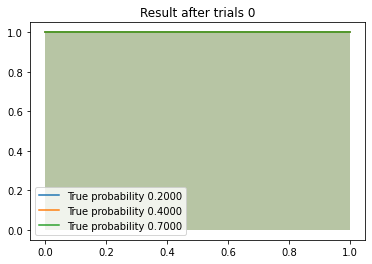

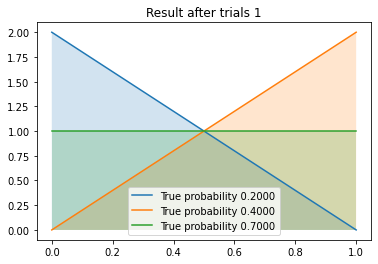

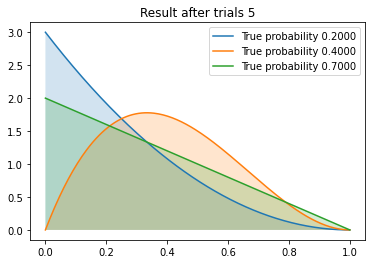

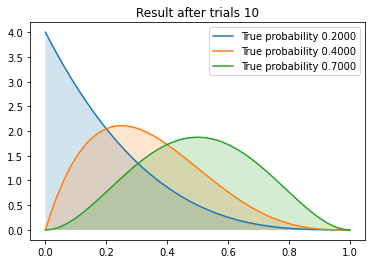

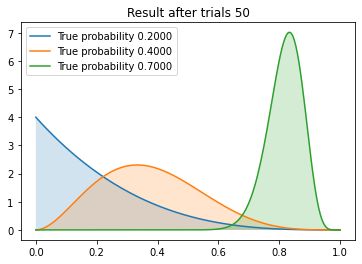

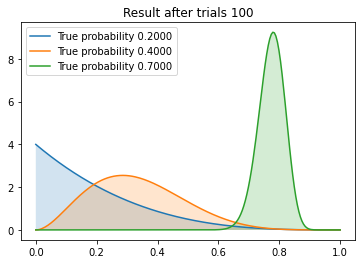

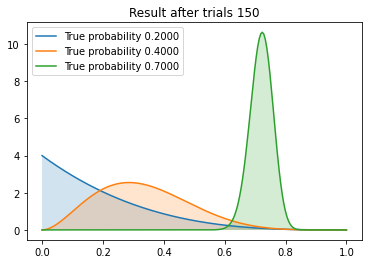

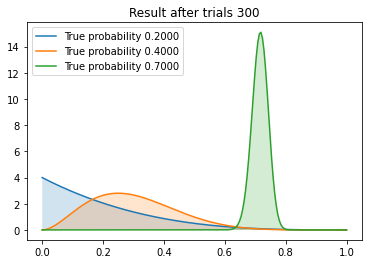

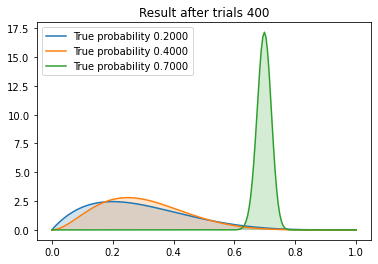

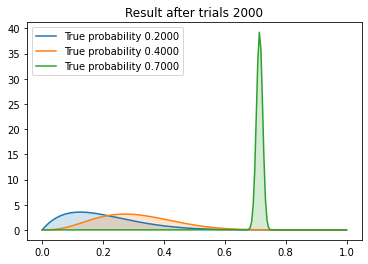

In [6]:
#
# setup experiment
#
true_probs = [0.2, 0.4, 0.7]
n_trials   = 2000
plot_steps = [1, 5, 10, 50, 100, 150, 300, 400]

# setup bandits
bandits = []
for p in true_probs:
  bandits.append(bandit(p))

# plot priors before we start
plot(bandits, 0)

#
# run trial
#
for i in range(0, n_trials):

  # we do not know yet which bandit to take
  best_bandit = None
  max_prob = -1

  # look at all bandits and see which one returns the highest probability of 
  # success
  for b in bandits:
    #evaluate prior
    prob = b.sample()
    if prob > max_prob:
      max_prob = prob
      best_bandit = b

  # choose the bandit with the highest probability
  outcome = best_bandit.execute()

  # update the prior of that bandit accordig to the result (success/failure)
  best_bandit.update(outcome)

  # make a plot of the priors
  if i in plot_steps:
    plot(bandits, i)

#plot priors at the end
plot(bandits, n_trials)
